### Porting the TTC model to Pytorch

**Done**: UNet, Conv-GN-SELU-DropBlock-SSE, equibatch, training data, adabound, Label smoothing, ConvGRU


**To do**: Zoneout, SAM, Boundary loss, 

In [1]:
import satlaspretrain_models
import torch
import pytorch_warmup as warmup
import adabound
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np
from torchvision.ops import drop_block2d
#%run ../src/pytorch/convgru.py
%run Pytorch_Unet.py --size 32

Initializing model with 1229963 params
Initializing dataset with 26080 length


In [2]:
model.load_state_dict(torch.load('modelgrumed.pt')['model_state_dict'])
model = model.to('mps')
model.eval()

TTCModel(
  (encoder): UNetEncoder(
    (gru): ConvGRU(
      (cell_list): ModuleList(
        (0): ConvGRUCell(
          (in_conv): Conv2d(49, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (out_conv): Conv2d(49, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (gn1): GroupNorm(4, 32, eps=1e-05, affine=True)
          (gn2): GroupNorm(4, 32, eps=1e-05, affine=True)
          (gn3): GroupNorm(4, 32, eps=1e-05, affine=True)
          (sse): SSEBlock(
            (spatial_se): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
    )
    (downblock10to20): UNetDownBlock(
      (conv): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): SiLU()
      (gn): GroupNorm(4, 32, eps=1e-05, affine=True)
      (sse): SSEBlock(
        (spatial_se): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (concatconv): UNetDownBlock(
      (conv): Conv2d(64, 64, ke

# Inference

In [6]:
import hickle as hkl
import seaborn as sns

def test_transform(input):
    med = np.median(input, axis = 0)
    input = np.reshape(input, (4, 3,input.shape[1], input.shape[2], input.shape[3]))
    input = np.median(input, axis = 1, overwrite_input = True)
    input = np.concatenate([input, med[np.newaxis]], axis = 0)
    #input = np.median(input, axis = 0)
    input = _normalize(input)
    input = np.moveaxis(input, -1, 1)
    #input = np.reshape(input, (input.shape[0]* input.shape[1], input.shape[2], input.shape[3]))
    print(input.shape)
    return input


#x = hkl.load('../src/1637X1088Y.hkl')
#



x = hkl.load('../src/2283X714Y.hkl')
#x = hkl.load('../src/2382X944Y.hkl')
x = test_transform(x)
#print(x.shape)
x = x[:, :, :512, :512]
print(x.shape)

(5, 17, 618, 600)
(5, 17, 512, 512)


In [7]:
with torch.no_grad():
    out = model(torch.tensor(x[np.newaxis]).to('mps'), train = False, drop_prob = 0.0)
    #print(x[0].shape)

<Axes: >

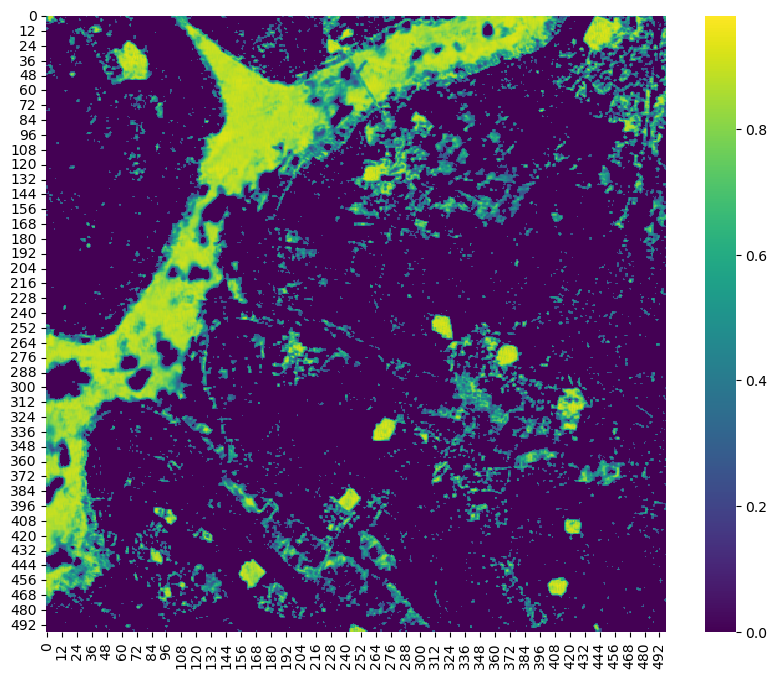

In [8]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))

pred = out[0].cpu().detach().numpy().squeeze()
pred[pred < 0.2] = 0.
sns.heatmap(pred, cmap = 'viridis', vmax = 0.98)

# Make the training data

In [19]:
import os
import hickle as hkl
import numpy as np
import rasterio as rs
fpath = '/Volumes/John/train-ard-128/'
ypath = '/Volumes/John/data/train-17k-may2023/train-y/'
output_xpath = '/Volumes/Macintosh HD/Users/work/Documents/ttc-training-data/input/'
output_ypath = '/Volumes/Macintosh HD/Users/work/Documents/ttc-training-data/target/'
x_files = [x[:-4] for x in os.listdir(fpath) if x[-4:] == '.hkl']
train_bad = [x[:-4] for x in os.listdir('/Volumes/John/data/train-17k-may2023/bad/')]
x_files = [x for x in x_files  if x not in train_bad]

In [31]:
# TCI (this is three channels, RGB; divide by 255)
# B05, B06, B07, B08, B11, B12 (divide by 8160, clip to 0-1)
# TTC is 4 3 2 8a 5 6 7 8 11 12
# SAT is 4 3 2 5 6 7 8 11 12
# 0, 1, 2, 4, 5, 6, 7, 

def write_output(fpath, ypath, f):
    ishkl = os.path.exists(fpath + f + '.hkl')
    if ishkl:
        out = hkl.load(fpath + f + '.hkl')
        if np.max(out) > 3:
            out = out / 65535
        
    else:
        out = np.load(fpath + f + ".npy")
        if np.max(out) > 3:
            out = out / 65535
    print(fpath + f + ".hkl")


    median = np.median(out, axis = 0)
    out = np.reshape(out, (4, 3, out.shape[1], out.shape[2], out.shape[3]))
    out = np.median(out, axis = 1, overwrite_input = True)
    out = np.concatenate([out, median[np.newaxis]], axis = 0)
    if os.path.exists(ypath + f + '.tif'):
        y = rs.open(ypath + f + '.tif').read(1)
    elif os.path.exists(ypath + f + '.npy'):
        y = np.load(ypath + f + '.npy')
    else:
        print(f"{f} Y does not exist")
        y = np.zeros((14, 14))
    print(np.mean(y))
    if np.max(y) < 10:
        y = y * 255
    if np.max(y) > 1:
        y = y / 255

    if os.path.exists(fpath + f + ".tif"):
        img = rs.open(fpath + f + ".tif").read()
        img = np.moveaxis(img, 0, 2)
    else:
        img = np.zeros_like(y)
    bord_clip = (out.shape[1] -  58) // 2
    bord_clip_y = (y.shape[1]-  14) // 2
    print(bord_clip, bord_clip_y)
    if bord_clip > 0:
        out = out[:, bord_clip:-bord_clip, bord_clip:-bord_clip :]
    out = out[:-1, ..., :10]
    if bord_clip_y > 0:
        y = y[bord_clip_y:-bord_clip_y, bord_clip_y:-bord_clip_y]
    out = np.delete(out, 3, -1)
    out = out * 65535
    out = np.uint16(out)
    return out, y

for i in x_files:
    x, y = write_output(fpath, ypath, i)
    if x.shape[1] == 58 and x.shape[2] == 58:
        if np.prod(y.shape) == 196:
            np.save(output_xpath + i + ".npy", x)
            np.save(output_ypath + i + ".npy", y)

/Volumes/John/train-ard-128/135680118.hkl
33.826530612244895
3 0
/Volumes/John/train-ard-128/228876300.hkl
164.65257
35 27
/Volumes/John/train-ard-128/135697464.hkl
7.8061224489795915
11 0
/Volumes/John/train-ard-128/6304050030.hkl
205.6122448979592
11 0
/Volumes/John/train-ard-128/400161.hkl
255.0
11 0
/Volumes/John/train-ard-128/594200024.hkl
132.00255102040816
35 0
/Volumes/John/train-ard-128/139378795.hkl
18.214285714285715
9 0
/Volumes/John/train-ard-128/136410791.hkl
1.3010204081632653
11 0
/Volumes/John/train-ard-128/135703205.hkl
33.826530612244895
11 0
/Volumes/John/train-ard-128/14639110020.hkl
0.0
11 0
/Volumes/John/train-ard-128/137535162.hkl
36.42857142857143
11 0
/Volumes/John/train-ard-128/139025358.hkl
157.4234693877551
35 0
/Volumes/John/train-ard-128/40088.hkl
0.0
11 0
/Volumes/John/train-ard-128/140860700.hkl
0.0
35 0
/Volumes/John/train-ard-128/136410949.hkl
184.74489795918367
11 0
/Volumes/John/train-ard-128/135542593.hkl
46.83673469387755
35 0
/Volumes/John/train-


KeyboardInterrupt

